### `chroma.ipynb`

This notebook indexes documents into a Chroma vector store using embedding models from Hugging Face.
Tools:
- Langchain
- Chroma
- Custom Loaders for Hugging Face and arXiv
- Custom Token Splitter (`TrainWiseTokenSplitter`) because the off-the-shelf ones of Langchain didn't work well (especially with arxiv documents)

You need to have a Hugging Face account to use the Inference API for embeddings.

In [1]:
import os
import sys
from dotenv import load_dotenv
from uuid import uuid4

from loaders import HuggingFaceBlogLoader, HuggingFaceDocsLoader, ArxivLoader
from data.utils import load_dataframe_from_sheet, get_docs

load_dotenv(override=True)

sys.path.append(os.path.abspath(".."))
FIRECRAWL_API_KEY = os.getenv("FIRECRAWL_API_KEY")
GOOGLE_SHEETS_ID = os.getenv("GOOGLE_SHEETS_ID")
GOOGLE_SHEETS_NAME = os.getenv("GOOGLE_SHEETS_NAME")
HF_TOKEN = os.getenv("HF_TOKEN")

%load_ext autoreload
%autoreload 2

### Load the documents dataframe

In [2]:
df = load_dataframe_from_sheet(GOOGLE_SHEETS_ID, GOOGLE_SHEETS_NAME)

### Load the documents using the custom Loaders (HF, arxiv)

In [3]:
hf_blogs_urls = get_docs(df, source="Hugging Face", doc_type="blog", urls_only=True)
hf_blogs_loader = HuggingFaceBlogLoader(firecrawl_api_key=FIRECRAWL_API_KEY, urls=hf_blogs_urls)
hf_blogs_docs = hf_blogs_loader.load()
hf_blogs_docs = hf_blogs_loader.clean(hf_blogs_docs)


Cleaning Hugging Face blogs: 100%|██████████| 5/5 [00:00<00:00, 4163.49it/s]


In [4]:
hf_docs_urls = get_docs(df, source="Hugging Face", doc_type="docs", urls_only=True)
hf_docs_loader = HuggingFaceDocsLoader(firecrawl_api_key=FIRECRAWL_API_KEY, urls=hf_docs_urls)
hf_docs_docs = hf_docs_loader.load()
hf_docs_docs = hf_docs_loader.clean(hf_docs_docs)

Cleaning Hugging Face docs: 100%|██████████| 23/23 [00:00<00:00, 4382.56it/s]


In [5]:
arxiv_urls = get_docs(df, source="arxiv", doc_type="paper", urls_only=True)
arxiv_loader = ArxivLoader(urls=arxiv_urls)
arxiv_docs = arxiv_loader.load()
arxiv_docs = arxiv_loader.clean(arxiv_docs)

Cleaning Arxiv papers: 100%|██████████| 3/3 [00:00<00:00, 603.53it/s]


In [7]:
all_docs = hf_blogs_docs + hf_docs_docs + arxiv_docs

print(f"Total documents loaded: {len(all_docs)}")

Total documents loaded: 31


### Split the documents into chunks using the custom TrainWiseTokenSplitter
We use the `nomic-ai/modernbert-embed-base`tokenizer but you can use any tokenizer you want.

In [8]:
from splitter import TrainWiseTokenSplitter
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nomic-ai/modernbert-embed-base")
# tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v2-base-code")
text_splitter = TrainWiseTokenSplitter(
    tokenizer = tokenizer,
    tokens_per_chunk = 1200,
    chunk_overlap = 200,
)
chunks = text_splitter.split_docs(all_docs)

Splitting documents into chunks: 100%|██████████| 31/31 [00:00<00:00, 68.01it/s] 


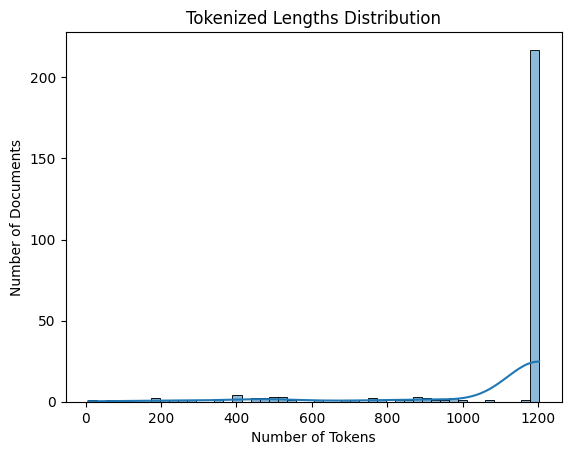

{'max_length': 1202, 'min_length': 7, 'average_length': 1100.095785440613}


In [10]:
from splitter import DocumentsTokensAnalysis
analyzer = DocumentsTokensAnalysis(tokenizer=tokenizer, docs=chunks)
analysis = analyzer.analyze(plot=True)
print(analysis)

### Load the Embedding model using Langchain HuggingFaceEndpointEmbeddings
Use your HF Token (I have a PRO subscription) to access the Inference API but they offer a fair amount of free calls as well.

In [11]:
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings


hf_embeddings = HuggingFaceEndpointEmbeddings(
    model= "nomic-ai/modernbert-embed-base",
    task="feature-extraction",
    huggingfacehub_api_token=HF_TOKEN,
)


### Indexing

In [12]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="trainwise_collection",
    embedding_function=hf_embeddings,
    persist_directory="./index",
)

We need to batch the chunks because hf endpoint has rate limits.

In [ ]:
def batch(iterable, size=16):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]

BATCH_SIZE = 16

for chunk_batch in batch(chunks, BATCH_SIZE):
    uuids = [str(uuid4()) for _ in range(len(chunk_batch))]
    vector_store.add_documents(chunk_batch, ids=uuids)

### Usage Example
find similar documents with a filter on the source metadata field

In [18]:
results = vector_store.similarity_search(
    "What is LoRA??",
    k=5,
    filter={"source": "hf"}
)
for res in results:
    print(f"* {res.page_content[:200]} [{res.metadata}]")


* [CLS]# LoRA

This conceptual guide gives a brief overview of [LoRA](https://arxiv.org/abs/2106.09685), a technique that accelerates
the fine-tuning of large models while consuming less memory.

To mak [{'url': 'https://huggingface.co/docs/peft/main/en/conceptual_guides/lora', 'title': 'LoRA', 'source': 'hf', 'description': 'Hugging Face Official Documentation of LoRA'}]
* [CLS]# LoRA

LoRA is low-rank decomposition method to reduce the number of trainable parameters which speeds up finetuning large models and uses less memory. In PEFT, using LoRA is as easy as setting  [{'title': 'LoRA', 'description': 'Hugging Face Official Documentation of LoRA', 'url': 'https://huggingface.co/docs/peft/main/en/developer_guides/lora', 'source': 'hf'}]
* . To use this option, _do not_ quantize the base model. Instead, proceed as follows:

Copied

```
from peft import LoftQConfig, LoraConfig, get_peft_model

base_model = AutoModelForCausalLM.from_pretr [{'description': 'Hugging Face Official Document